In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from ipywidgets import interact_manual

%matplotlib inline

In [2]:
def PLOTTING_DENSITY(ax, data, title):
    plt.imshow(data, aspect='equal')
    plt.xticks(np.linspace(0,N,5),fontsize=8.0)
    plt.yticks(np.linspace(0,N,5),fontsize=8.0)
    axins = inset_axes(ax,
                       width="5%",  # width = 50% of parent_bbox width
                       height="60%",  # height : 5%
                       loc='upper right',
                       bbox_to_anchor=(0.15, -0.2, 1, 1),#(position_x, position_y, bbox_size_x, bbox_size_y)
                       bbox_transform=ax.transAxes)
    cb = plt.colorbar(shrink=0.3, aspect=10, cax=axins)
    ax.set_title("%s"%title, y=1.05, fontsize=12.0)
    ax.set_xlabel('$x$', fontsize = 8.0)
    ax.set_ylabel('$y$', fontsize = 8.0)
    cb.set_ticks(np.linspace(data.min(), data.max(),5))
    
def PLOTTING_SPECTURM(ax, data, title): 
    # plot the power spectrum
    data_copy = 2*data
    plt.imshow(data_copy, cmap = 'jet', aspect='equal')   # log|A|**2=2log|A|
    plt.xticks(np.linspace(0,N,5), np.linspace(-N//2,N//2,5),fontsize=8.0)
    plt.yticks(np.linspace(0,N,5), np.linspace(-N//2,N//2,5),fontsize=8.0)
    axins = inset_axes(ax,
                       width="5%",  # width = 50% of parent_bbox width
                       height="60%",  # height : 5%
                       loc='upper right',
                       bbox_to_anchor=(0.15, -0.2, 1, 1),#(position_x, position_y, bbox_size_x, bbox_size_y)
                       bbox_transform=ax.transAxes)
    cb = plt.colorbar(shrink=0.3, aspect=10, cax=axins)
    ax.set_title("%s"%title, y=1.05, fontsize=12.0)
    ax.set_xlabel('$k_x(2\pi/N)$', fontsize = 8.0)
    ax.set_ylabel('$k_y(2\pi/N)$', fontsize = 8.0)
    cb.set_ticks(np.linspace(data_copy.min(), data_copy.max(),5))

def CONDSTRUCT_FILTER(sigma, N):
    x = np.arange(N)
    center = N//2
    x = np.exp(-0.5*((x-center)/sigma)**2)
    x = np.roll(x, N//2)
    xx,yy = np.meshgrid(x,x)
    FILTER = xx*yy
    return FILTER/FILTER.sum()

def CONVOLUTION(signal, conv_filter):
    u_k = np.fft.rfft2(conv_filter)
    f_k = np.fft.rfft2(signal)
#     u_k = np.ones_like(f_k)
    sperctrum = u_k*f_k
    return np.fft.irfft2(sperctrum), abs(sperctrum)  

def GET_FILTERED_RESULT(sigma=1):
#     global spectrum_density
    trunication = -15
    FILTER = CONDSTRUCT_FILTER(sigma,N)
    data_density_conv, spectrum_density = CONVOLUTION(data_density, FILTER)
    spectrum_density = np.hstack((spectrum_density,spectrum_density[:,-2:0:-1]))
    spectrum_density = np.roll(spectrum_density, N//2, axis=0)
    spectrum_density = np.roll(spectrum_density, N//2, axis=1)
    criteria = np.where(spectrum_density<=10**trunication)
    
    fig = plt.figure(figsize=(3,3*2), dpi=200)
    plt.subplots_adjust(hspace=0.5)
    ax_1 = fig.add_subplot(2, 1, 1)
    PLOTTING_DENSITY(ax_1, data_density_conv, title='Gaussian Filter with σ=%d Applied'%sigma)
    ax_2 = fig.add_subplot(2, 1, 2)
    
    if len(criteria)!=0:
        spectrum_density[criteria] = 10**trunication
        
    A = np.log10(spectrum_density)    
    PLOTTING_SPECTURM(ax_2, A, title='Power Spectrum of Gaussian Filter with σ=%d\n(log Scale)'%sigma)
    plt.show()
    mean_k_x, mean_k_y, sigma_k_x, sigma_k_y = GET_STATISTIC(spectrum_density,N)
    print("Mean of k_x is %.8f ; mean of k_y is %.8f ."%(mean_k_x, mean_k_y))
    print("Variance of k_x is %.8f ; variance of k_y is %.8f ."%(sigma_k_x**0.5, sigma_k_y**0.5))
    
def GET_STATISTIC(data,N):
    normalization = data.sum()
    data_normalized = data.copy()/normalization
    x = np.arange(N)-(N+1)//2
    xx, yy = np.meshgrid(x,x)
    mean_k_x = (data_normalized*xx).sum()
    mean_k_y = (data_normalized*yy).sum()
    sigma_k_x = (data_normalized*xx**2).sum()-mean_k_x**2
    sigma_k_y = (data_normalized*yy**2).sum()-mean_k_y**2
    return mean_k_x, mean_k_y, sigma_k_x, sigma_k_y

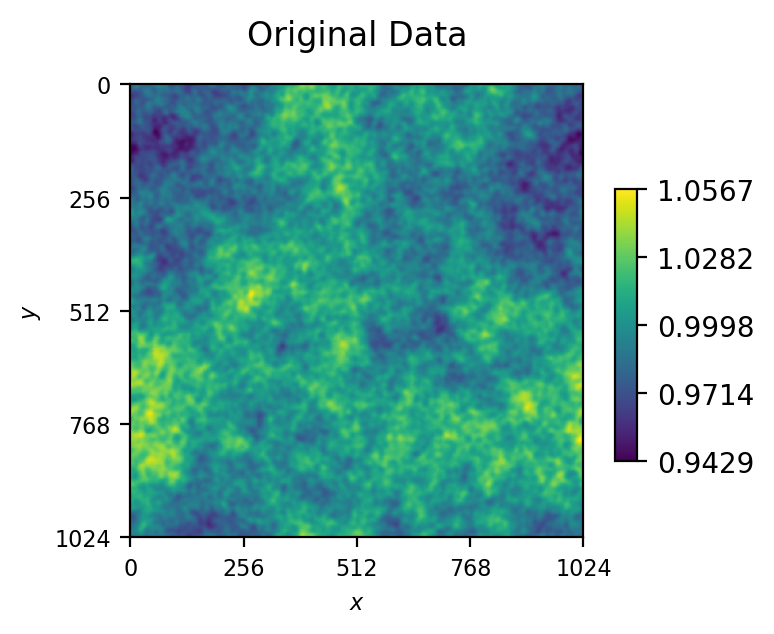

In [4]:
N = 1024
data_density = np.fromfile('./density.dat','float32').reshape(N,N)
figure = plt.figure(figsize=(3,3), dpi=200)
ax = plt.subplot(111)
PLOTTING_DENSITY(ax, data_density, title = 'Original Data')

In [535]:
# N = data_density.shape[0]
interact_manual(GET_FILTERED_RESULT, sigma=2**np.arange(0,10));

interactive(children=(Dropdown(description='sigma', options=(1, 2, 4, 8, 16, 32, 64, 128, 256, 512), value=1),…

In [559]:
trunication = -15
sigma_range = 2**np.arange(0,10)
mean_k_x_record = []
mean_k_y_record = []
var_k_x_record = []
var_k_y_record = []

for sigma in sigma_range:
    FILTER = CONDSTRUCT_FILTER(sigma,N)
    data_density_conv, spectrum_density = CONVOLUTION(data_density, FILTER)
    spectrum_density = np.hstack((spectrum_density,spectrum_density[:,-2:0:-1]))
    spectrum_density = np.roll(spectrum_density, N//2, axis=0)
    spectrum_density = np.roll(spectrum_density, N//2, axis=1)
    criteria = np.where(spectrum_density<=10**trunication)
    
    if len(criteria)!=0:
        spectrum_density[criteria] = 10**trunication
        
    mean_k_x, mean_k_y, sigma_k_x, sigma_k_y = GET_STATISTIC(spectrum_density,N)
    mean_k_x_record.append(mean_k_x)
    mean_k_y_record.append(mean_k_y)
    var_k_x_record.append(sigma_k_x**0.5)
    var_k_y_record.append(sigma_k_y**0.5)

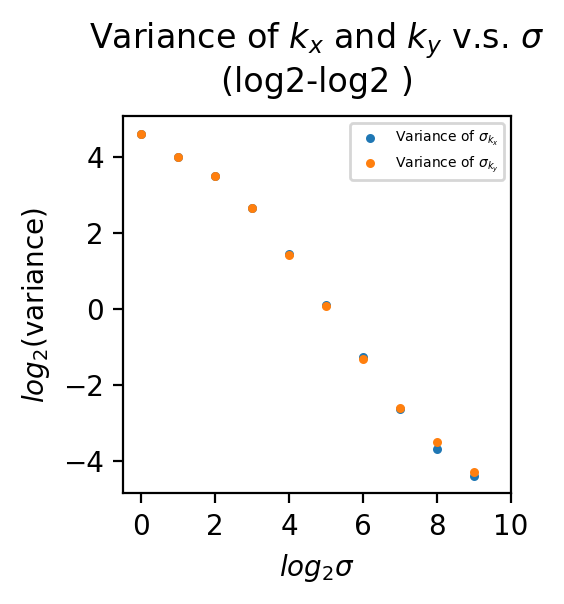

In [561]:
plt.figure(figsize=(2.5,2.5), dpi=200)
plt.scatter(np.log2(sigma_range), np.log2(var_k_x_record), s=5.0, label='Variance of $\sigma_{k_x}$')
plt.scatter(np.log2(sigma_range), np.log2(var_k_y_record), s=5.0, label='Variance of $\sigma_{k_y}$')
plt.xlabel('$log_2\sigma $')
plt.ylabel('$log_2$(variance)')
plt.title('Variance of $k_x$ and $k_y$ v.s. $\sigma$\n(log2-log2 )', y=1.02)
plt.xticks(np.arange(0,12,2))
plt.yticks(np.arange(-4,6,2))
plt.legend(loc='upper right', prop={'size':5.0})
plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW4/log2-log2_variance_v.s._sigma.png", bbox_inches='tight', dpi=200, pad_inches=0.05)

In [482]:
bin_center_list = []
his_list = []
trunication = -15

1.0000001
Mean of k_x is -0.01238478 ; mean of k_y is 0.07347417 .
Variance of k_x is 58.20387650 ; variance of k_y is 58.87456062 .


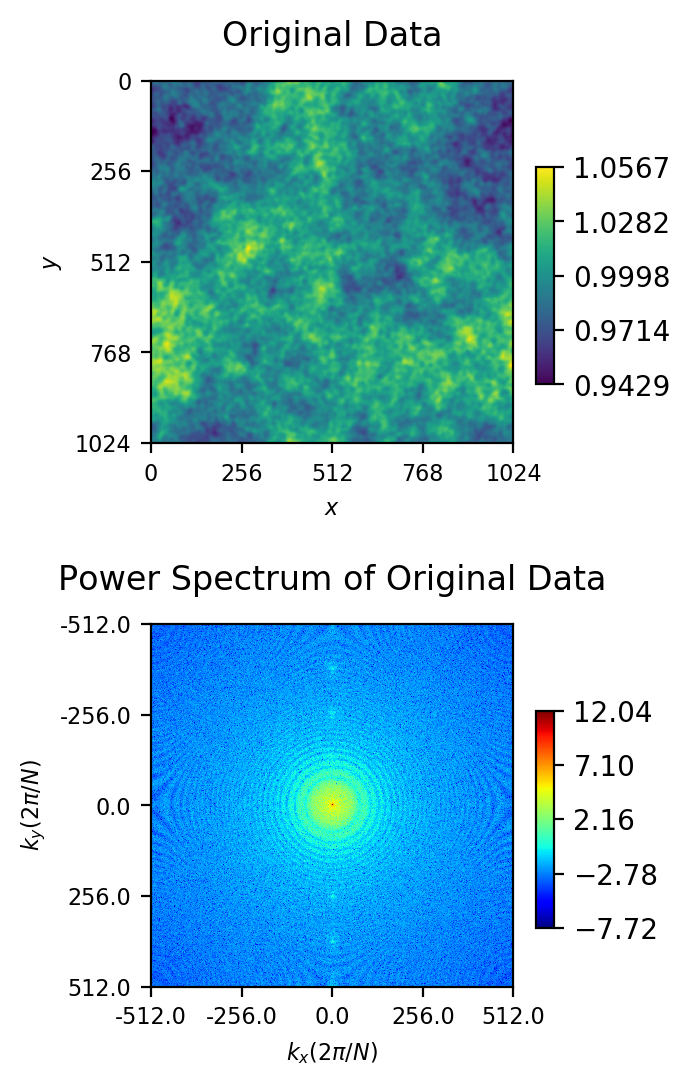

In [551]:
spectrum_density = abs(np.fft.rfft2(data_density))
spectrum_density = np.hstack((spectrum_density,spectrum_density[:,-2:0:-1]))
spectrum_density = np.roll(spectrum_density, N//2, axis=0)
spectrum_density = np.roll(spectrum_density, N//2, axis=1)
criteria = np.where(spectrum_density<=10**trunication)

if len(criteria)!=0:
    spectrum_density[criteria] = 10**trunication

fig = plt.figure(figsize=(3,3*2), dpi=200)
plt.subplots_adjust(hspace=0.5)
ax_1 = fig.add_subplot(2, 1, 1)
PLOTTING_DENSITY(ax_1, data_density, title='Original Data')
ax_2 = fig.add_subplot(2, 1, 2)
A = np.log10(spectrum_density)    
PLOTTING_SPECTURM(ax_2, A, title='Power Spectrum of Original Data')

plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW4/original.png", bbox_inches='tight', dpi=200, pad_inches=0.05)

his, bin_range = np.histogram(data_density, range=(data_density.min(),data_density.max()), bins=20)
bin_center = 0.5*(bin_range[:-1]+bin_range[1:])
bin_center_list.append(bin_center.copy())
his_list.append(his.copy())
mean_k_x, mean_k_y, sigma_k_x, sigma_k_y = GET_STATISTIC(spectrum_density,N)
print("Mean of k_x is %.8f ; mean of k_y is %.8f ."%(mean_k_x, mean_k_y))
print("Variance of k_x is %.8f ; variance of k_y is %.8f ."%(sigma_k_x**0.5, sigma_k_y**0.5))

1.0000000000000004
Mean of k_x is -0.00000000 ; mean of k_y is 0.01195221 .
Variance of k_x is 4.86205933 ; variance of k_y is 4.85042083 .


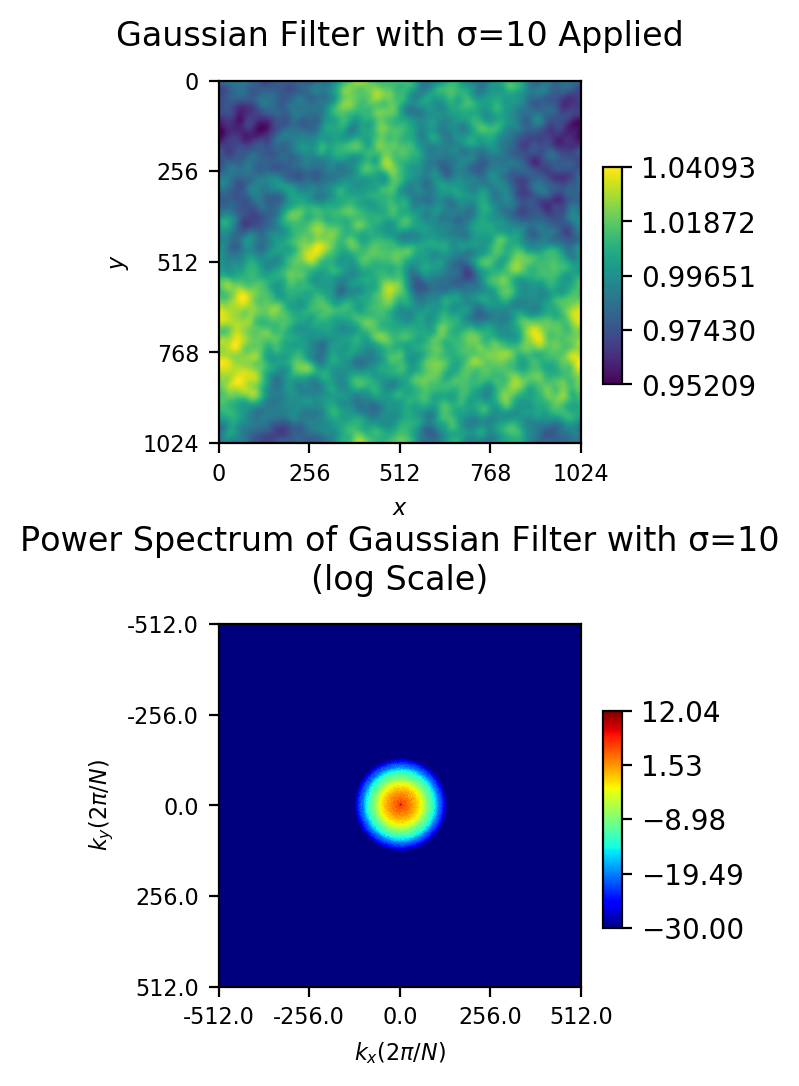

In [555]:
FILTER = CONDSTRUCT_FILTER(sigma=10,N=N)
data_density_conv, spectrum_density = CONVOLUTION(data_density, FILTER)
spectrum_density = np.hstack((spectrum_density,spectrum_density[:,-2:0:-1]))
spectrum_density = np.roll(spectrum_density, N//2, axis=0)
spectrum_density = np.roll(spectrum_density, N//2, axis=1)
criteria = np.where(spectrum_density<=10**trunication)

if len(criteria)!=0:
    spectrum_density[criteria] = 10**trunication

fig = plt.figure(figsize=(3,3*2), dpi=200)
plt.subplots_adjust(hspace=0.5)
ax_1 = fig.add_subplot(2, 1, 1)
PLOTTING_DENSITY(ax_1, data_density_conv, title='Gaussian Filter with σ=%d Applied'%10)
ax_2 = fig.add_subplot(2, 1, 2)
A = np.log10(spectrum_density)    
PLOTTING_SPECTURM(ax_2, A, title='Power Spectrum of Gaussian Filter with σ=%d\n(log Scale)'%10)
plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW4/sigma=10.png", bbox_inches='tight', dpi=200, pad_inches=0.05)

his, bin_range = np.histogram(data_density_conv, range=(data_density_conv.min(),data_density_conv.max()), bins=20)
bin_center = 0.5*(bin_range[:-1]+bin_range[1:])
bin_center_list.append(bin_center.copy())
his_list.append(his.copy())
mean_k_x, mean_k_y, sigma_k_x, sigma_k_y = GET_STATISTIC(spectrum_density,N)
print("Mean of k_x is %.8f ; mean of k_y is %.8f ."%(mean_k_x, mean_k_y))
print("Variance of k_x is %.8f ; variance of k_y is %.8f ."%(sigma_k_x**0.5, sigma_k_y**0.5))

1.0000000000000002
Mean of k_x is -0.00000000 ; mean of k_y is 0.00344000 .
Variance of k_x is 0.22526556 ; variance of k_y is 0.22104553 .


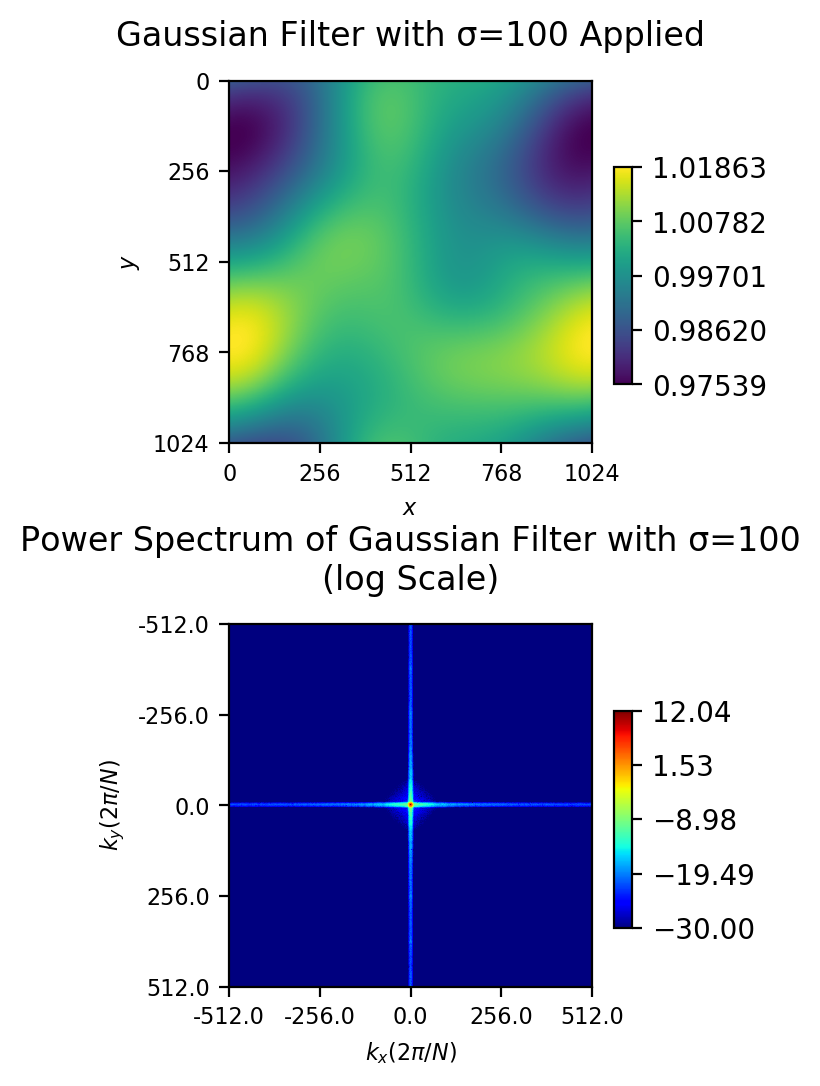

In [556]:
FILTER = CONDSTRUCT_FILTER(sigma=100,N=N)
data_density_conv, spectrum_density = CONVOLUTION(data_density, FILTER)
spectrum_density = np.hstack((spectrum_density,spectrum_density[:,-2:0:-1]))
spectrum_density = np.roll(spectrum_density, N//2, axis=0)
spectrum_density = np.roll(spectrum_density, N//2, axis=1)
criteria = np.where(spectrum_density<=10**trunication)

if len(criteria)!=0:
    spectrum_density[criteria] = 10**trunication

fig = plt.figure(figsize=(3,3*2), dpi=200)
plt.subplots_adjust(hspace=0.5)
ax_1 = fig.add_subplot(2, 1, 1)
PLOTTING_DENSITY(ax_1, data_density_conv, title='Gaussian Filter with σ=%d Applied'%100)
ax_2 = fig.add_subplot(2, 1, 2)
A = np.log10(spectrum_density)    
PLOTTING_SPECTURM(ax_2, A, title='Power Spectrum of Gaussian Filter with σ=%d\n(log Scale)'%100)

plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW4/sigma=100.png", bbox_inches='tight', dpi=200, pad_inches=0.05)

his, bin_range = np.histogram(data_density_conv, range=(data_density_conv.min(),data_density_conv.max()), bins=20)
bin_center = 0.5*(bin_range[:-1]+bin_range[1:])
bin_center_list.append(bin_center.copy())
his_list.append(his.copy())
mean_k_x, mean_k_y, sigma_k_x, sigma_k_y = GET_STATISTIC(spectrum_density,N)
print("Mean of k_x is %.8f ; mean of k_y is %.8f ."%(mean_k_x, mean_k_y))
print("Variance of k_x is %.8f ; variance of k_y is %.8f ."%(sigma_k_x**0.5, sigma_k_y**0.5))

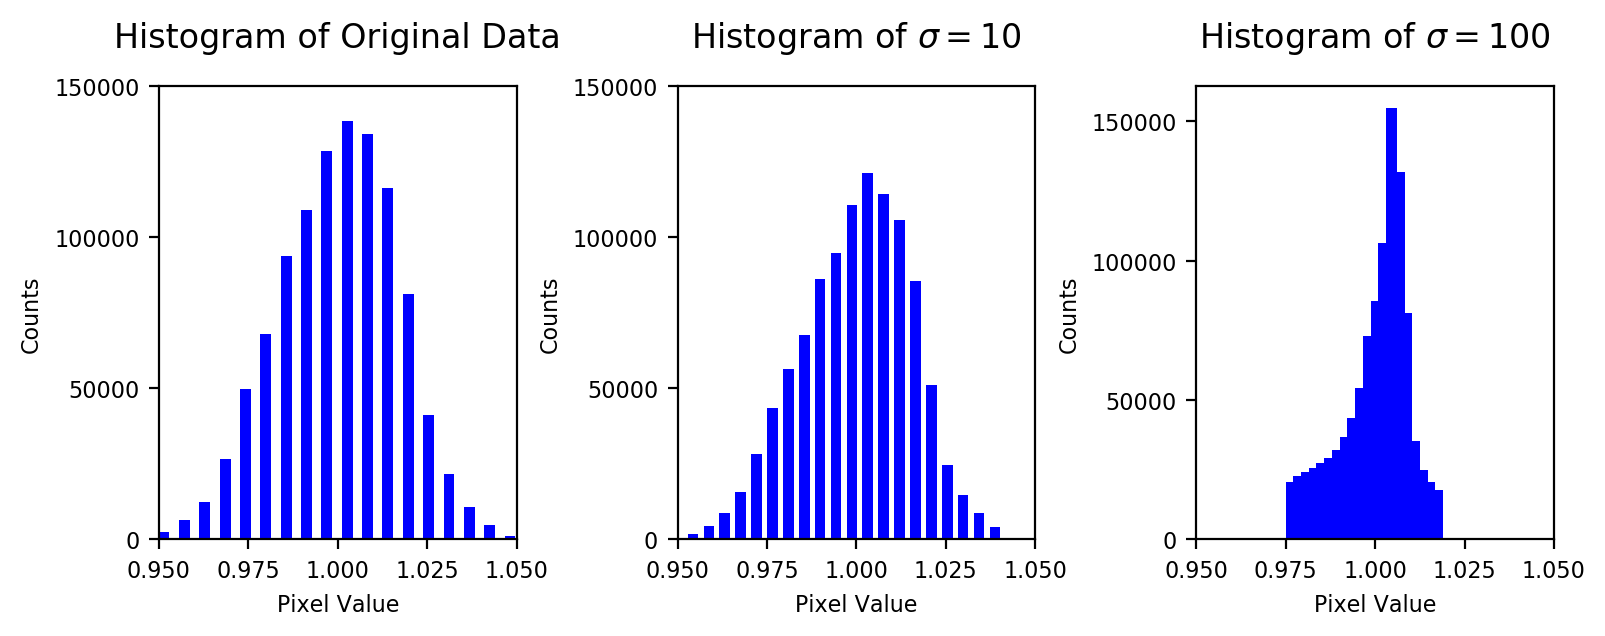

In [554]:
plt.figure(figsize=(3*3,3), dpi=200)
plt.subplots_adjust(wspace=0.45)
title_list = ["Histogram of Original Data","Histogram of $\sigma = 10$","Histogram of $\sigma = 100$"]
for i in range(3):
    if i==0:
        plt.subplot(131)
    elif i==1:
        plt.subplot(132)
    else:
        plt.subplot(133)
    plt.bar(bin_center_list[i], his_list[i], width=0.003,color='blue')
    plt.xlabel("Pixel Value",fontsize=8)
    plt.ylabel("Counts",fontsize=8)
    plt.title(title_list[i], fontsize=12, y=1.05)
    plt.yticks(np.linspace(0,150000,4),fontsize=8)
    plt.xticks(np.linspace(0.95,1.05,5),fontsize=8)
    plt.xlim([0.95,1.05])
plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW4/pixel_value_histogram.png", bbox_inches='tight', dpi=200, pad_inches=0.05)

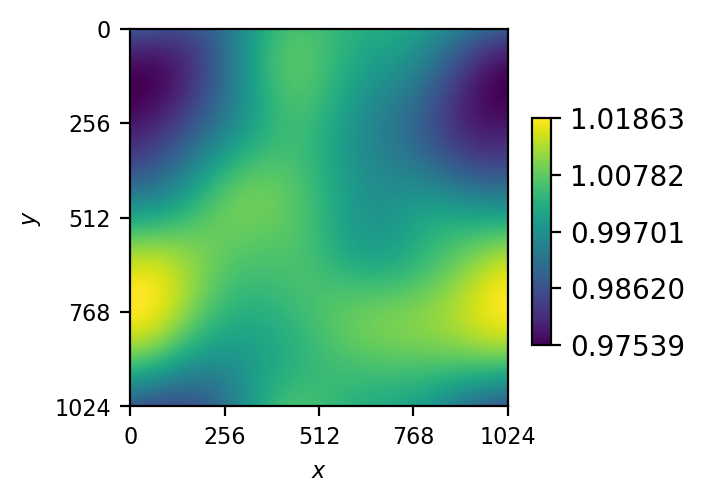

In [513]:
fig = plt.figure(figsize=(2.5,2.5), dpi=200)
plt.subplots_adjust(hspace=0.5)
ax_1 = fig.add_subplot(1, 1, 1)
PLOTTING_DENSITY(ax_1, data_density_conv, title='')
plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW4/x_symmetry_and_y_symmetry.png", bbox_inches='tight', dpi=200, pad_inches=0.05)